Created by Zain Eris Kamal (zain.eris.kamal@rutgers.edu) on 5/17/23.

Purpose:
- Representative crustal thickness in Henry crater without layering.
    - Henry crater has layering, likely aeolian deposits, which bias Wieczorek's crustal thickness data (derived from topology minus moho).  
- Calculate the range of crustal thickness value at Henry crater with different interior models.

---
---
## 0. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import math
from scipy.optimize import curve_fit


import zerisk.Utils as utils

In [2]:
''' Load crater data '''

import zerisk.Craters

path__datahome = utils.getPath('current','..','data','1_raw')

Craters = zerisk.Craters.Craters()
Craters.downloadData(path__datahome, overwrite=False, verbose=True)

Craters.loadData(minDiam=70, maxDiam=1000, extraInfo=True)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\craters. 
To overwrite, add `overwrite=True` param.



---
---
## 1. Previous Work

### 1.1. Elevation

![](https://files.catbox.moe/tr7lso.png)

---
### 1.2. Wieczorek Crustal Thickness Map

In [3]:
''' Load crustal thickness data '''

import zerisk.Crust
Crust = zerisk.Crust.Crust()

path__datahome = utils.getPath('current','..','data','1_raw')
Crust.downloadData(path__datahome, overwrite=False, verbose=True)

Crust.loadData(ref_interior_model_int=0)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_thickness. 
To overwrite, add `overwrite=True` param.



In [4]:
def plot_craterCrThick_2D(identifier, scaling, spacing):

    if '-' in identifier:
        thiscrater = Craters.getByID(identifier)
    else:
        thiscrater = Craters.getByName(identifier)

    # thiscrater = Craters.getByName(crater_name)
    radius_th = Craters.km2theta(thiscrater['diam']/2)

    lon_left = thiscrater['lon']-radius_th*scaling
    lon_right = thiscrater['lon']+radius_th*scaling
    lat_bottom = thiscrater['lat']-radius_th*scaling
    lat_top = thiscrater['lat']+radius_th*scaling

    dat = []

    for lat in np.arange(lat_bottom, lat_top, spacing):
        newline = []
        for lon in np.arange(lon_left, lon_right, spacing):
            x = Crust.getThickness(lon, lat)
            newline.append(x)
        dat.append(newline)

        
    # dat = np.asarray(dat)
    # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)

    if thiscrater['name'] == '':
        name = thiscrater['id']
    else:
        name = thiscrater['name']

    ax.set_title(f'Crustal Thickness at {name}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.xaxis.set_major_formatter('{x}$\degree$')
    ax.yaxis.set_major_formatter('{x}$\degree$')

    cbar.set_label('Crustal Thickness (km)',y=0.5)

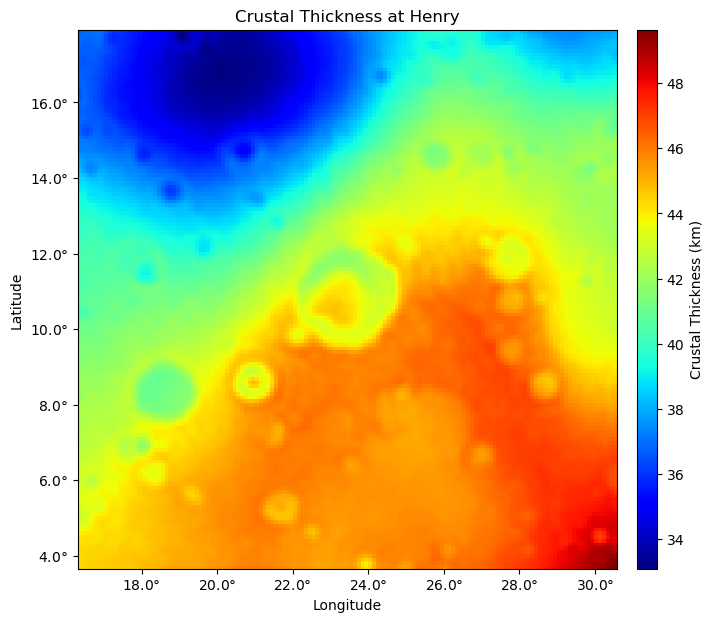

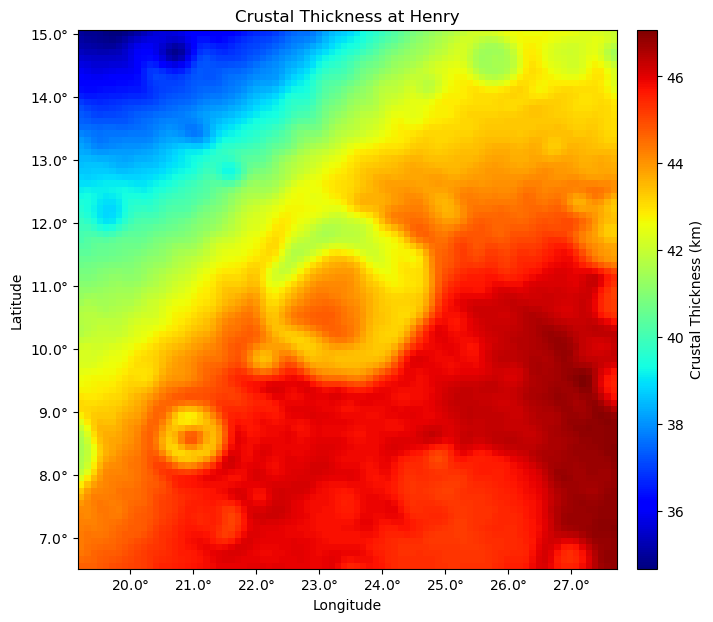

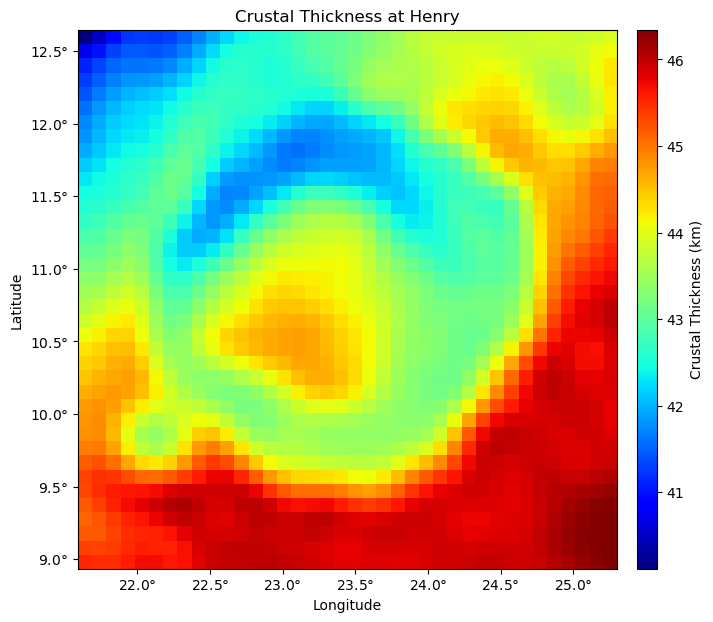

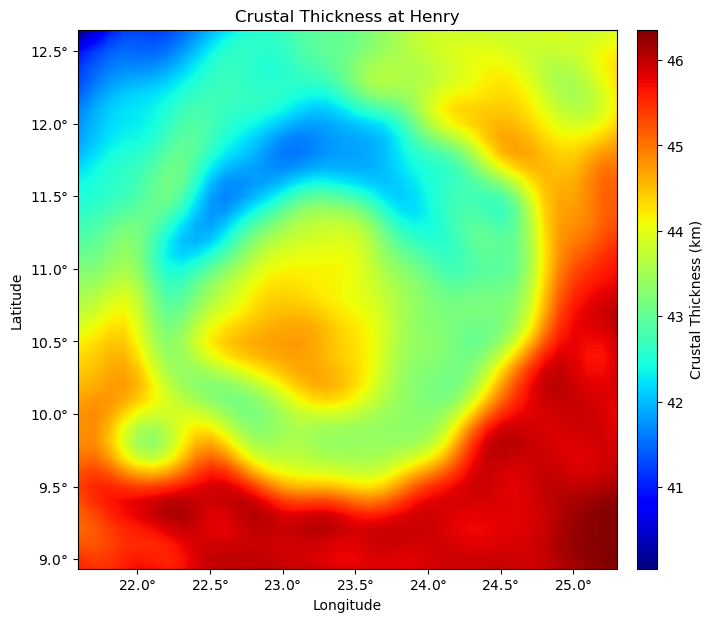

In [5]:
crater_name = 'Henry'
plot_craterCrThick_2D(crater_name, 5, 0.1)
plot_craterCrThick_2D(crater_name, 3, 0.1)
plot_craterCrThick_2D(crater_name, 1.3, 0.1)
plot_craterCrThick_2D(crater_name, 1.3, 0.01)

---
---
## 2. Crater Cross-Sections

### 2.1. Henry Cross-sections

Text(0, 0.5, 'Crustal Thickness [km]')

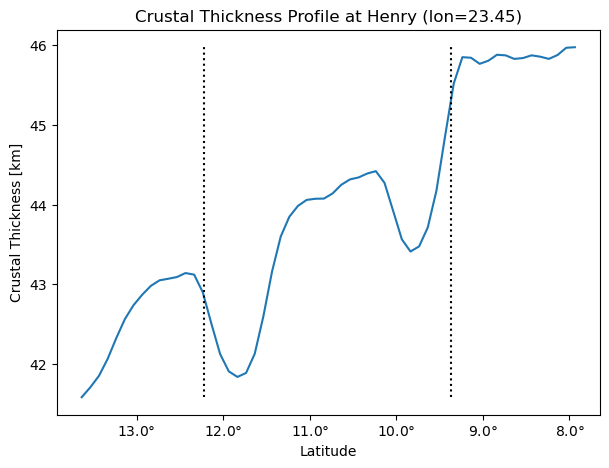

In [6]:
crater_name = 'Henry'
scaling = 2
spacing = 0.1


thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)


lon = thiscrater['lon']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th
lat_bottom = thiscrater['lat']-radius_th*scaling
lat_top = thiscrater['lat']+radius_th*scaling


lat_range = np.arange(lat_bottom, lat_top, spacing)


dat = []

for lat in lat_range:
    dat.append(Crust.getThickness(lon, lat))

dat = np.asarray(dat)


fig = plt.figure(figsize=(7,5))
ax = plt.axes()
lin = ax.plot(lat_range, dat)

ax.invert_xaxis()

ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

ax.set_title(f'Crustal Thickness Profile at {crater_name} (lon={lon:0.2f})')
ax.set_xlabel('Latitude')
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.set_ylabel('Crustal Thickness [km]')

Text(0, 0.5, 'Crustal Thickness [km]')

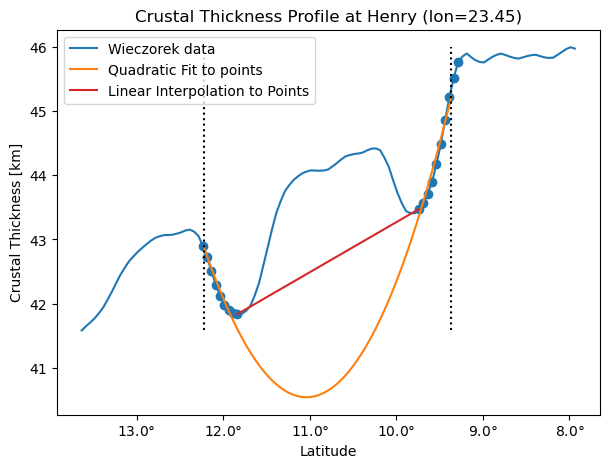

In [7]:
''' Get cross-sectional data '''

crater_name = 'Henry'
scaling = 2
spacing = 0.05


thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)


lon = thiscrater['lon']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th
lat_bottom = thiscrater['lat']-radius_th*scaling
lat_top = thiscrater['lat']+radius_th*scaling


lat_range = np.arange(lat_bottom, lat_top, spacing)


dat = []

for lat in lat_range:
    dat.append(Crust.getThickness(lon, lat))

dat = np.asarray(dat)





''' Isolate un-altered crater data + quadratic fit '''

bounds = [9.25, 9.75, 11.8, 12.27]

ind = np.where((bounds[0] < lat_range) & (lat_range < bounds[1]) | (bounds[2] < lat_range) & (lat_range < bounds[3]))
lat_range_crop = lat_range[ind]
dat_crop = dat[ind]





def model_f(x,a,b,c):
    return a*(x-b)**2 + c

popt, pcov = curve_fit(model_f, lat_range_crop, dat_crop, p0=[1,11,45])

a_opt, b_opt, c_opt = popt
x_model = np.linspace(crater_lat_bottom, crater_lat_top, 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt)




''' Plot data'''


fig = plt.figure(figsize=(7,5))
ax = plt.axes()

lin_dat, = ax.plot(lat_range, dat, color='C0')
lin_dat.set_label('Wieczorek data')

scatt_training = ax.scatter(lat_range_crop, dat_crop, color='C0')

lin_quad_fit, = ax.plot(x_model, y_model, color='C1')
lin_quad_fit.set_label('Quadratic Fit to points')


# linear model

left = np.abs(lat_range_crop-bounds[1]).argmin()
right = np.abs(lat_range_crop-bounds[2]).argmin()
lin_linear_fit, = ax.plot([lat_range_crop[left], lat_range_crop[right]], [dat_crop[left], dat_crop[right]], color='C3')
lin_linear_fit.set_label('Linear Interpolation to Points')


# plotting

ax.legend()

ax.invert_xaxis()

ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

ax.set_title(f'Crustal Thickness Profile at {crater_name} (lon={lon:0.2f})')
ax.set_xlabel('Latitude')
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.set_ylabel('Crustal Thickness [km]')

In [8]:
# # np.where(lat_range == np.amin(lat_range-bounds[1]))
# print(lat_range)
# left = np.abs(lat_range_crop-bounds[1]).argmin()
# print(left)
# print(lat_range_crop[left])

### 2.2. Other Craters

In [9]:
# Craters_170 = zerisk.Craters.Craters()
# Craters_170.downloadData(path__datahome, overwrite=False, verbose=True)

# Craters_170.loadData(minDiam=160, maxDiam=180, extraInfo=True)

In [10]:
# Craters_170.getData()

In [11]:
# crater_name = 'Henry'
# scaling = 2
# spacing = 0.1


# def plot_craterCrThick_crossSection(thiscrater, scaling, spacing):

#     # if '-' in identifier:
#     #     thiscrater = Craters.getByID(identifier)
#     # else:
#     #     thiscrater = Craters.getByName(identifier)

#     radius_th = Craters.km2theta(thiscrater['diam']/2)


#     lon = thiscrater['lon']
#     crater_lat_bottom = thiscrater['lat']-radius_th
#     crater_lat_top = thiscrater['lat']+radius_th
#     lat_bottom = thiscrater['lat']-radius_th*scaling
#     lat_top = thiscrater['lat']+radius_th*scaling


#     lat_range = np.arange(lat_bottom, lat_top, spacing)


#     dat = []

#     for lat in lat_range:
#         dat.append(Crust.getThickness(lon, lat))

#     dat = np.asarray(dat)


#     fig = plt.figure(figsize=(7,5))
#     ax = plt.axes()
#     lin = ax.plot(lat_range, dat)

#     ax.invert_xaxis()

#     ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

#     if thiscrater['name'] == '':
#         name = thiscrater['id']
#     else:
#         name = thiscrater['name']

#     ax.set_title(f'Crustal Thickness Profile at {name} (lon={lon:0.2f}, diam={thiscrater["diam"]:0.2f})')
#     ax.set_xlabel('Latitude')
#     ax.xaxis.set_major_formatter('{x}$\degree$')
#     ax.set_ylabel('Crustal Thickness [km]')

#     # fig.show()

In [12]:
# for i in range(21):
#     # print(f'{i} -------------------------------\n')
#     thisID = Craters_170.getData().iloc[i].to_dict()['id']
#     plot_craterCrThick_2D(thisID, 3, 0.1)
#     plot_craterCrThick_crossSection(Craters_170.getByID(thisID), 2, 0.1)

---
---
## 3. New Crustal Thickness Models

In [13]:
# ''' reduce a folder of crustal thickness files '''

# folder = utils.getPath(r'C:\Users\Eris\Documents\sync_local\00_Local\mars\scripts\InSight-Crustal-Thickness-Archive\grids\generated_230611')


# import os


# for filename in os.listdir(folder):

#     # filename = os.listdir(folder)[0]

#     fin = utils.getPath(folder, filename)

#     dat = np.loadtxt(fin, delimiter=',')
#     dat = dat[:,2]

#     new_filename = filename[ :filename.index('.xyz') ] + '__shortened__grid=0.1.npy' # transforms 'prefix.xyz' into 'prefix__shortened__grid=0.1.npy'

#     np.save(
#         file = utils.getPath('current', new_filename),
#         arr = dat
# )

In [14]:
# ''' loading with new format (changes to Crust.py interface) '''

# import zerisk.Crust
# Crust = zerisk.Crust.Crust()

# path__datahome = utils.getPath('current','..','data','1_raw')
# Crust.downloadData(path__datahome, overwrite=False, verbose=True)

# Crust.loadData(ref_interior_model_int=0)

In [15]:
## constants

crater_name = 'Henry'

thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)

crater_lon_center = thiscrater['lon']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th

lat_bounds = [9.25, 9.75, 11.8, 12.25]



## linear interp

lat1 = lat_bounds[1]
lat2 = lat_bounds[2]
thick1 = Crust.getThickness(crater_lon_center, lat1)
thick2 = Crust.getThickness(crater_lon_center, lat2)

